In [ ]:
from google.colab import drive # Liên kết Drive với Colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install h5py # Dowloand h5py để thuận tiện cho việc lưu model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opencv-python # Dowloand thư viện Opencv cho xử lý ảnh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Khai báo các thư viện cần thiết
import pandas as pd
import numpy as np
import cv2
import time
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from cv2 import cvtColor

In [ ]:
# Khai báo các hàm cần sử dụng

# Lật ảnh
def horizontal_flip(image, steering_angle):
    # Lật ảnh theo chiều ngang (Đối xứng trục y)
    flipped_image = cv2.flip(image, 1)
    
    # Đảo ngược góc lái
    steering_angle = -steering_angle
    
    return flipped_image, steering_angle

# Giảm ngẫu nhiên độ sáng cho ảnh
def brightness_reduction(image):
    # Chuyển ảnh từ form màu RGB sang HSV để giảm độ snags
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Chuyển đổi kiểu dữ liệu của pixel ảnh thành số thực cho tính toán dễ dàng 
    image = np.array(image, dtype = np.float64)
    
    # Điều chỉnh độ sáng bằng cách thay đổi thông số V của ảnh
    random_brightness = 1 - np.random.uniform(0.2, 0.4)
    image[:,:,2] = image[:,:,2] * random_brightness
    
    # Chuyển đổi lại kiểu dữ liệu cho pixel của ảnh uint8 
    image = np.array(image, dtype = np.uint8)
    
    # Chuyển ảnh lại snag form màu RGB
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    
    return image

# Dịch chuyển ảnh ngẫu nhiên theo trục x và trục y
def translation(image, steering_angle, x_trans_range = [-60, 60], y_trans_range = [-20, 20]):
    # Lấy kích thước của ảnh
    height, width = (image.shape[0], image.shape[1])
    
    # Xác đinh độ dịch chuyển của ảnh dọc theo trục x và dọc theo trục y
    x_trans = np.random.randint(x_trans_range[0], x_trans_range[1]) 
    y_trans = np.random.randint(y_trans_range[0], y_trans_range[1])
    
    # Điều chỉnh lại góc lại theo trục x
    steering_angle += x_trans * 0.004
    
    # Tạo ma trận dịch chuyển ảnh (chỉ dịch chuyển đơn thuần theo trục x và y)
    trans_matrix = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
    
    # Dịch chuyển ảnh sử dụng warpAffine
    translated_image = cv2.warpAffine(image, trans_matrix, (width, height))
    
    return translated_image, steering_angle

# Cắt phần vùng bầu trờ của ảnh
def top_bottom_crop(image):
    # Cắt ảnh theo chiều trục y trong khoảng pixel từ 40 - 125
    cropped_image = image[40:135, :]
    
    return cropped_image

# Kết hợp các phương pháp augmention xử lý ảnh
def augment_image(df):
    # Lấy một giá trị ngẫu nhiên trong khoản từ 0 3
    camera_side = np.random.randint(3)

    # Điều chỉnh lại góc tuỳ theo các loại ảnh từ các góc cam
    if camera_side == 0:
        image_path = df.iloc[0]['center_camera'].strip()
        angle_calib = 0
    elif camera_side == 1:
        image_path = df.iloc[0]['left_camera'].strip()
        angle_calib = 0.25
    elif camera_side == 2:
        image_path = df.iloc[0]['right_camera'].strip()
        angle_calib = -0.25

    steering_angle = df.iloc[0]['steering_angle'] + angle_calib

    # Đọc ảnh dùng thư viện opencv
    image = cv2.imread(image_path)

    # Chuyển ảnh từ form BGR sang RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    # Ngẫu nhiên augmention ảnh

    if np.random.rand() < 0.5:
        # Dịch chuyển ảnh
        image, steering_angle = translation(image, steering_angle)

    if np.random.rand() < 0.5:
        # Giảm độ sáng của ảnh
        image = brightness_reduction(image)

    if np.random.rand() < 0.5:
        # Lật ảnh
        image, steering_angle = horizontal_flip(image, steering_angle)

    return image, steering_angle

# Tiền xử lý ảnh
def image_preprocessing(image):
    # Cắt ảnh
    image = top_bottom_crop(image)

    # Chuyển ảnh từ form RGB sang YUV cho dễ dàng xử lý
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    # Resize ảnh
    image = cv2.resize(image, (200, 66), interpolation = cv2.INTER_AREA)

    # Scale ảnh
    image = image / 255

    return image

def batch_generator(df, batch_size, training_flag):
    while True:
        # Tạo 1 list lưu ảnh và góc sau khi xử lý từ batch
        images_bacth = []
        steering_angles_batch = []

        for i in range(batch_size):
            # Chọn một hàng ngẫu nhiên với địa chỉ
            index = np.random.randint(0, len(df) - 1)

            # Augmentation lại ảnh cho dữ liệu training
            if training_flag:
                # Augmentation lại ảnh
                image, steering_angle = augment_image(df.iloc[[index]])
            else:
                camera_side = np.random.randint(3)

                # Điều chỉnh lại góc tuỳ theo các loại ảnh từ các góc cam
                if camera_side == 0:
                    image_path = df.iloc[0]['center_camera'].strip()
                    angle_calib = 0
                elif camera_side == 1:
                    image_path = df.iloc[0]['left_camera'].strip()
                    angle_calib = 0.25
                elif camera_side == 2:
                    image_path = df.iloc[0]['right_camera'].strip()
                    angle_calib = -0.25

                # Đọc ảnh tại form RGB
                image = cv2.imread(image_path)
                steering_angle = df.iloc[0]['steering_angle'] + angle_calib

            # Tiền xử lý ảnh
            image = image_preprocessing(image)

            # Add ảnh và góc lái vào các list trên
            images_batch.append(image)
            steering_angles_batch.append(steering_angle)

        yield (np.asarray(images_batch), np.asarray(steering_angles_batch))


In [ ]:
# Tải dữ liệu
col_names = ['center_camera', 'left_camera', 'right_camera', 'steering_angle', 'throttle', 'brake', 'speed']
df = pd.read_csv('/content/gdrive/MyDrive/Data/Self_driving_car/driving_log.csv', names = col_names)

print('Total Images Imported: ', df.shape[0])

Total Images Imported:  4495


In [ ]:
# Chia dữ liệu thành tập train và tập val (80/20)
train_df, val_df = train_test_split(df, test_size = 0.2)
print('Total Training Images: ', len(train_df))
print('Total Validation Images: ', len(val_df), '\n')

Total Training Images:  3596
Total Validation Images:  899 



In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [ ]:
# Xây dựng model
model = Sequential()

model.add(Conv2D(24, (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))

model.add(layers.Conv2D(36, (5, 5), strides = (2, 2), activation = 'elu'))

model.add(layers.Conv2D(48, (5, 5), strides = (2, 2), activation = 'elu'))

model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), activation = 'elu'))

model.add(layers.Conv2D(64, (3, 3), strides = (1, 1), activation = 'elu'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu'))

model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))

model.add(Dense(10, activation='elu'))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
# Thiết lập các thông số
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))

In [ ]:
# Training Model
h = model.fit(batch_generator(train_df, batch_size = 64, training_flag = 1),
              steps_per_epoch = 1000, epochs = 25, 
              validation_data = batch_generator(val_df, batch_size = 64, training_flag = 0),
              validation_steps = 1000, callbacks=[early_stop])

Epoch 1/25
1000/1000 [==============================] - 7123s 7s/step - loss: 0.0613 - val_loss: 0.0318
Epoch 2/25
1000/1000 [==============================] - 538s 539ms/step - loss: 0.0477 - val_loss: 0.0193
Epoch 3/25
1000/1000 [==============================] - 549s 550ms/step - loss: 0.0427 - val_loss: 0.0384
Epoch 4/25
1000/1000 [==============================] - 550s 551ms/step - loss: 0.0401 - val_loss: 0.0344
Epoch 5/25
1000/1000 [==============================] - 518s 518ms/step - loss: 0.0382 - val_loss: 0.0468
Epoch 6/25
1000/1000 [==============================] - 522s 523ms/step - loss: 0.0361 - val_loss: 0.1111
Epoch 7/25
1000/1000 [==============================] - 524s 525ms/step - loss: 0.0351 - val_loss: 0.1091
Epoch 8/25
1000/1000 [==============================] - 518s 518ms/step - loss: 0.0332 - val_loss: 0.0757
Epoch 9/25
1000/1000 [==============================] - 518s 519ms/step - loss: 0.0332 - val_loss: 0.0689
Epoch 10/25
1000/1000 [=========================

In [ ]:
model.save('/content/gdrive/MyDrive/Data/Self_driving_car/model.h5')

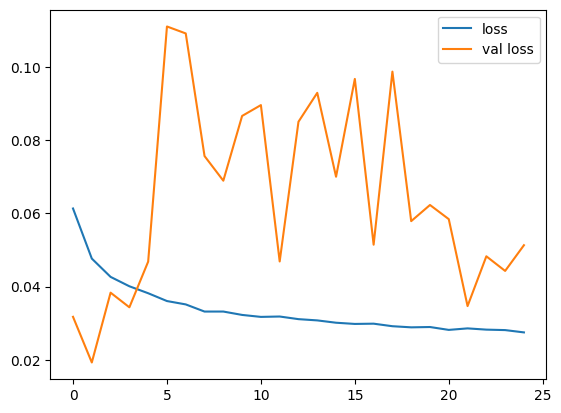

In [ ]:
# Vẽ đồ thị tương quan giữa hàm loss và hàm val loss
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()